# Реализация логистической регрессии в TensorFlow

In [2]:
import numpy as np
import tensorflow as tf

print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


## Генерируем данные для задачи классификации

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples = 1000,# число объектов
                           n_features = 2,# число признаков
                           n_informative = 2,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 1)

y = y.reshape(-1, 1)
y = np.double(y)

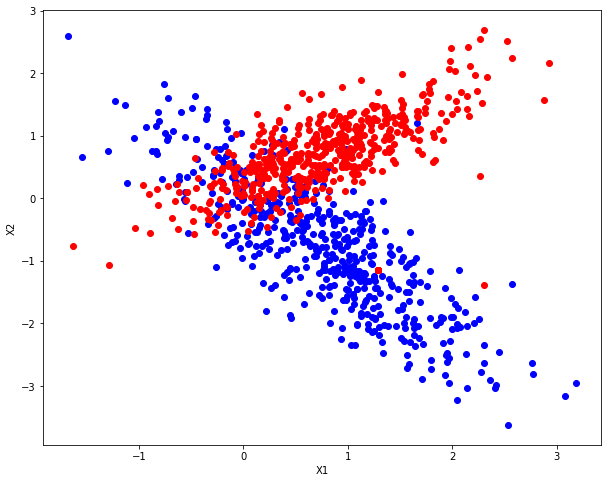

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.figure(figsize=(10, 8))
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or')
plt.xlabel('X1')
plt.ylabel('X2');

## Логистическая регрессия

$$p_i=\frac{1}{1 + e^{-(x_i \cdot w + b)}}$$

$$loss=-\sum y_i\log(p_i) + (1 - y_i)\log(1 - p_i)$$

## Функции для обучения модели

In [5]:
@tf.custom_gradient
def sigmoid(x):
    x = tf.convert_to_tensor(x)
    s = 1. / (1. + tf.exp(-x))
    
    def grad(dy):
        # TODO: реализовать шаг градиента для функции sigmoid
        dy = dy * (1 - 1 / (1 + s))
        
        return dy
    return s, grad

def log_loss(y, prediction):
    y = tf.convert_to_tensor(y)
    loss = y * tf.math.log(prediction)
    loss += (1. - y) * tf.math.log(1. - prediction)
    return - tf.reduce_mean(loss)

def accuracy(y, y_pred):
    y_pred = np.where(y_pred > 0.5, 1., 0.)
    return 1.0 * np.sum(y_pred == y) / len(y)

## Обучение модели

In [7]:
# создаем переменные для хранения весов модели
w = tf.Variable(
    #2-число признаков
    np.random.normal(size=(2, 1)),
    dtype=tf.double, name='w')

b = tf.Variable(0.0, dtype=tf.double, name='b')

# функция для вычисления предсказание модели
def predict(x):
    x = tf.convert_to_tensor(x)
    d = tf.matmul(x, w)
    return sigmoid(d + b)


# разделяем выборку на обучающую и на тестовую группы
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.33,
                                     random_state=12345)

test_loss_results = []
test_accuracy_results = []

lr = 5e-2  # скорость обучения

for i in range(300):
    with tf.GradientTape() as g:
        # вычисляем значение функции потерь для обучающей выборки
        y_pred = predict(X_train)
        loss = log_loss(y_train, y_pred)

    # вычисляем значение градиента для параметров модели
    dw, db = g.gradient(loss, [w, b])

    # обновляем параметры модели с учетом значений градиентов
    w.assign_sub(lr * dw)
    b.assign_sub(lr * db)

    if i % 10 == 0:
        # логируем метрики на тестовой выборке
        y_pred = predict(X_test)
        test_loss_results.append(log_loss(np.double(y_test), y_pred).numpy())
        test_accuracy_results.append(accuracy(y_test, y_pred.numpy()))
        print('[%03d] loss=%.3f acc=%.3f' % (i,
                                             test_loss_results[-1],
                                             test_accuracy_results[-1]))

[000] loss=1.489 acc=0.464
[010] loss=1.292 acc=0.455
[020] loss=1.111 acc=0.470
[030] loss=0.950 acc=0.485
[040] loss=0.811 acc=0.512
[050] loss=0.699 acc=0.545
[060] loss=0.612 acc=0.636
[070] loss=0.547 acc=0.767
[080] loss=0.500 acc=0.833
[090] loss=0.466 acc=0.858
[100] loss=0.441 acc=0.852
[110] loss=0.423 acc=0.845
[120] loss=0.410 acc=0.845
[130] loss=0.400 acc=0.842
[140] loss=0.393 acc=0.842
[150] loss=0.388 acc=0.842
[160] loss=0.385 acc=0.842
[170] loss=0.383 acc=0.836
[180] loss=0.381 acc=0.836
[190] loss=0.380 acc=0.833
[200] loss=0.380 acc=0.827
[210] loss=0.379 acc=0.827
[220] loss=0.379 acc=0.824
[230] loss=0.378 acc=0.833
[240] loss=0.377 acc=0.833
[250] loss=0.377 acc=0.833
[260] loss=0.376 acc=0.845
[270] loss=0.375 acc=0.845
[280] loss=0.374 acc=0.845
[290] loss=0.373 acc=0.848


## Визуализируем кривую обучения

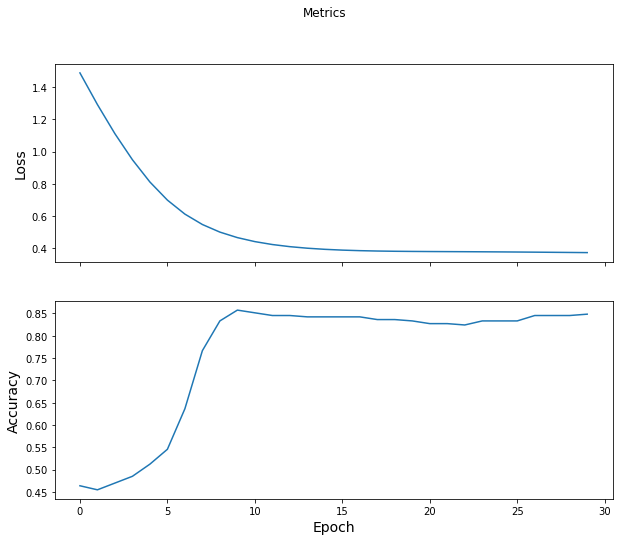

In [8]:
fig, axes = plt.subplots(2, sharex=True, figsize=(10, 8))
fig.suptitle('Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(test_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(test_accuracy_results)
plt.show()

## Визуализируем разделяющую гиперплоскость 

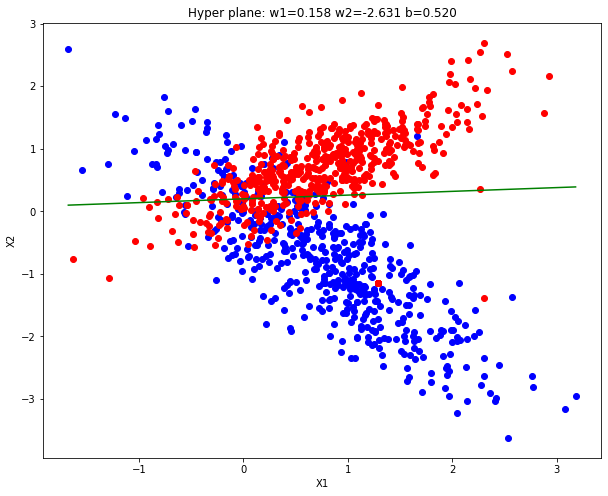

In [9]:
w1, w2 = w.numpy()

plane = - X[:, 0] * w1 / w2 - b.numpy() / w2

order = np.argsort(X[:, 0])

plt.figure(figsize=(10, 8))
plt.title('Hyper plane: w1=%.3f w2=%.3f b=%.3f'
          % (w1, w2, b.numpy()))

plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], plane[order], '-g')

plt.xlabel('X1')
plt.ylabel('X2');